In [1]:
import pandas as pd
import xgboost as xgb
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # For logging values within training loop
import torch.onnx
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
# Load dataset
df = pd.read_csv('AmazonDataSales_v2.csv', low_memory=False)
# Drop all columns except 'amount', 'category', 'size', 'quantity'
df = df[['amount', 'category', 'size', 'qty']]

# One-hot encode the 'category', 'size', and 'qty' columns
# Select all columns except 'amount' as feature columns
feature_columns = df.columns.drop('amount')
# One-hot encode the feature columns
df_encoded = pd.get_dummies(df, columns=feature_columns)

# Assuming 'df' contains your dataset
X = df_encoded.drop('amount', axis=1)  # Features
y = df['amount']  # Target

#Network stopped converging, the only things I did was add hooks and remove this line
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Convert to numpy arrays (required for PyTorch tensors)
X_np = np.array(X, dtype=np.float32)
y_np = np.array(y, dtype=np.float32)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_np)
y_tensor = torch.tensor(y_np)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create TensorDatasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=200, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)

In [4]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Logging during training
writer = SummaryWriter()

In [ ]:
# Function to register hooks for monitoring activations
def register_activation_hooks(model, writer):
    def hook_fn(module, input, output):
        writer.add_histogram(f"{module.__class__.__name__}_activations", output)

    for layer in model.modules():
        if isinstance(layer, torch.nn.modules.Linear):
            # Use a closure to capture the current layer
            layer.register_forward_hook(lambda module, input, output, layer=layer: hook_fn(layer, input, output))


# Function to register hooks for monitoring gradients
def register_gradient_hooks(model, writer):
    for name, parameter in model.named_parameters():
        def hook(grad, name=name):  # Capture current value of name
            writer.add_histogram(f"{name}_gradients", grad)
        parameter.register_hook(hook)


# Function to log weights, needs no fancy hooks
def log_weights(model, writer, epoch):
    for name, param in model.named_parameters():
        writer.add_histogram(f"{name}_weights", param, epoch)


In [5]:
class FeedForwardRegressor(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(FeedForwardRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)  # Output layer for regression

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

# Model instantiation and move to device
input_size = X_train.shape[1]
hidden_size1 = 2
hidden_size2 = 2
model = FeedForwardRegressor(input_size, hidden_size1, hidden_size2).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [ ]:
#Training function with logging

def train_model(model, train_loader, criterion, optimizer, writer, num_epochs=10):
    model.train()
    register_activation_hooks(model, writer)  # Register activation hooks // register_forward_hook
    register_gradient_hooks(model, writer)     # Register gradient hooks


    for epoch in range(num_epochs):
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            # Move data to the device
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Log weights and gradients for the first batch in each epoch
            if batch_idx == 0:
                for name, param in model.named_parameters():
                    writer.add_histogram(f"{name}_weights", param, epoch) #parameter_hook
                    writer.add_histogram(f"{name}_grads", param.grad, epoch) #?_hook

            # Log weights at the end of each epoch
            log_weights(model, writer, epoch)

        # Log loss at each epoch
        writer.add_scalar('Loss/train', total_loss/len(train_loader), epoch)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

In [ ]:
# Evaluation function

def evaluate_model(model, test_loader):
    model.eval()
    targets_list = []
    outputs_list = []
    with torch.no_grad():
        total_loss = 0
        for inputs, targets in test_loader:
            # Move data to the device
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))  # Add an extra dimension to targets

            total_loss += loss.item()
            targets_list.append(targets.cpu())
            outputs_list.append(outputs.cpu())
        
        # Concatenate all batches
        all_targets = torch.cat(targets_list, dim=0)
        all_outputs = torch.cat(outputs_list, dim=0)

        # Calculate R-squared score
        r2 = r2_score(all_targets.numpy(), all_outputs.numpy())
        
        print(f'Test Loss: {total_loss/len(test_loader)}')
        print(f'R-squared: {r2}')

In [ ]:
# Run training
train_model(model, train_loader, criterion, optimizer, writer, num_epochs=5)

In [ ]:
# and evaluation
evaluate_model(model, test_loader) 

In [ ]:
# How many features or inputs do the model receive 
input_size = X_train.shape[1]
print(input_size)

In [ ]:
from torchsummary import summary
summary(model, input_size=(input_size,)) # The , after input_size needs to be there

In [8]:
# Use the saved model in the form of a state dictionary

# Define model parameters
input_size = X_train.shape[1]  # Make sure X_train.shape[1] is accessible here
hidden_size1 = 2
hidden_size2 = 2

# Initialize the model
model = FeedForwardRegressor(input_size, hidden_size1, hidden_size2)  # Replace with your model class and parameters

#Load saved model
model.load_state_dict(torch.load('C:\BIA\Kurs8\Inlamning2\Experiment6\model_state_dict_0.42.pt'))

#Load to GPU
model.to(device)

FeedForwardRegressor(
  (fc1): Linear(in_features=24, out_features=2, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=2, out_features=2, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=2, out_features=1, bias=True)
)

In [9]:
# Running the saved model

# Assuming model is correctly loaded and moved to the appropriate device
model.eval()  # Set the model to evaluation mode

# No need to manually specify input_data since you're using DataLoader
test_targets_list = []
test_outputs_list = []

with torch.no_grad():  # Disable gradient computation
    for inputs, targets in test_loader:
        inputs = inputs.to(device)  # Ensure inputs are on the correct device
        targets = targets.to(device)  # Ensure targets are on the correct device
        outputs = model(inputs)
        test_targets_list.append(targets)
        test_outputs_list.append(outputs)

# Concatenate all the outputs and targets from the test set
all_test_targets = torch.cat(test_targets_list, dim=0).cpu().numpy()
all_test_outputs = torch.cat(test_outputs_list, dim=0).cpu().numpy()

# Now, you can calculate metrics such as MSE or R2 for the test set
test_mse = mean_squared_error(all_test_targets, all_test_outputs)
test_r2 = r2_score(all_test_targets, all_test_outputs)

print(f"Test MSE: {test_mse}")
print(f"Test R-squared: {test_r2}")


Test MSE: 35291.22265625
Test R-squared: 0.4205197008902992


In [10]:
#Function for plotting Residuals
residual_outliers =[]

def evaluate_model_and_plot_residuals(model, test_loader, df_original):
    model.eval()
    targets_list = []
    outputs_list = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            targets_list.append(targets.cpu())
            outputs_list.append(outputs.cpu())

    all_targets = torch.cat(targets_list, dim=0).numpy()
    all_outputs = torch.cat(outputs_list, dim=0).numpy()

    # Calculate R-squared score
    r2 = r2_score(all_targets, all_outputs)
    print(f'R-squared: {r2}')

    # Calculate residuals
    residuals = all_targets - all_outputs.squeeze()

    # Durbin-Watson Test
    #durbin_watson = stats.durbin_watson(residuals)
    #print(f'Durbin-Watson: {durbin_watson}')

    # Shapiro-Wilk Test for normality
    shapiro_test = stats.shapiro(residuals)
    print(f'Shapiro-Wilk Test: Statistic={shapiro_test[0]}, p-value={shapiro_test[1]}')

    # Identify outliers based on residuals
    threshold = np.percentile(np.abs(residuals), 95)  # You can adjust this threshold
    outlier_indices = np.where(np.abs(residuals) > threshold)[0]
    outliers_info = df_original.iloc[outlier_indices]



    return outliers_info, residuals, all_targets, all_outputs


Shapiro-Wilk test seems to imply a non-normal distribution. The general case for a good distribution is a normal distribution. And, of course, that the points lie close to zero. So not very good.

In [11]:
import matplotlib.pyplot as plt
# Plot residuals and save some information about targets, outputs and residuals
outliers_info_df, residuals, all_targets, all_outputs = evaluate_model_and_plot_residuals(model, test_loader, df)

R-squared: 0.4205197008902992
Shapiro-Wilk Test: Statistic=0.9402319989481666, p-value=4.170641926008741e-69


C:\Users\Tono\AppData\Local\Temp\ipykernel_11748\4020116415.py:30: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 23516.
  shapiro_test = stats.shapiro(residuals)


##### Residuals
Residual = Real Value - Predicted Value
They look decently randomly scattered to my eyes to begin with. But a long way off from zero. And in "buckets" As there aren't just "buckets" of values in the targets, that's not a good sign.  
How can you visually spot a good and normal distribution?  
You can think of it like this: Move all the points across the vertical line to the left. Most should end up around the zero point with a few higher up or lower down. then you have a normal distribution.  
The other thing to think about is that the outliers should be evenly spaced along the x-axis. If most are above zero, or below, that's a bad thing.

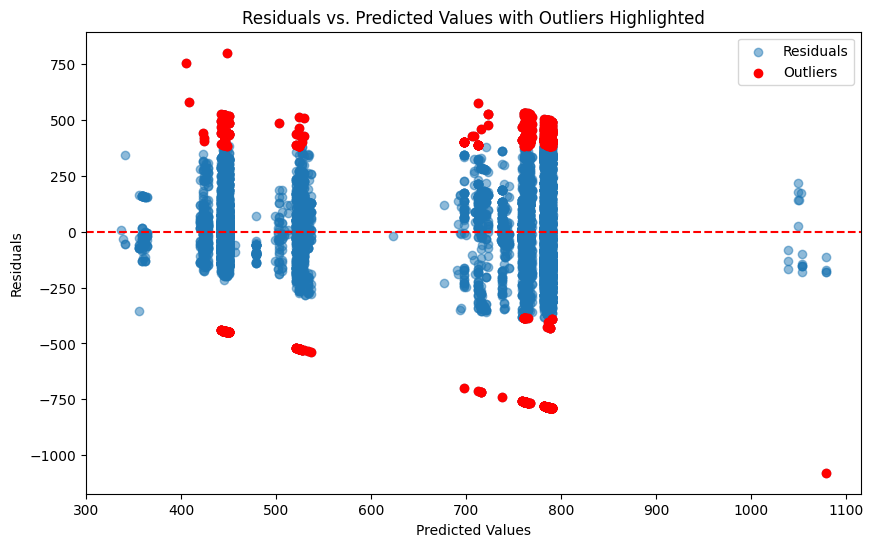

In [12]:
# Plotting residual outliers 

# First, let's plot all residuals
plt.figure(figsize=(10, 6))
plt.scatter(all_outputs, residuals, alpha=0.5, label='Residuals')

# Now, let's plot the outliers. We'll need to calculate their residuals specifically.
# If outliers_info_df contains the indices of the outliers, we'll use those to index into all_outputs and residuals.
outlier_residuals = residuals[outliers_info_df.index]
outlier_predictions = all_outputs[outliers_info_df.index]

plt.scatter(outlier_predictions, outlier_residuals, color='red', label='Outliers')

plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values with Outliers Highlighted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()


Plotting predicted and actual values tells us something about how the model fails. The predictions are bad in general and completely fails to predict the zero values.

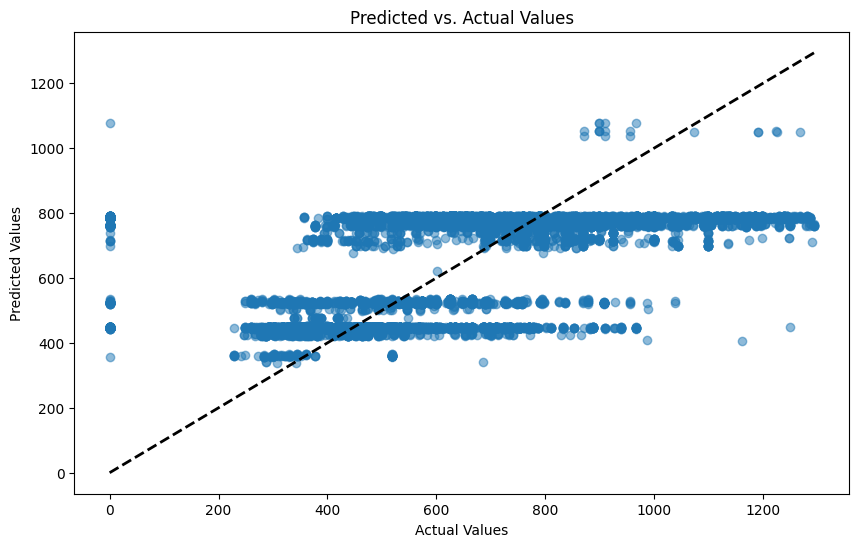

In [13]:
# Assuming all_targets are the true values and all_outputs are the model's predictions
plt.figure(figsize=(10, 6))
plt.scatter(all_targets, all_outputs, alpha=0.5)
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([all_targets.min(), all_targets.max()], [all_targets.min(), all_targets.max()], 'k--', lw=2)  # Diagonal line
plt.show()
